# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Целью настоящего исследования является создание модели, способной спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Модель будет строиться на исторических данных о поведении клиентов и расторжении договоров с банком. 

Отбор подходящей модели будет производиться  по значению F1-меры для пололжительного класса (положительный класс классификации - клиенты, расторгнувшие договор). Цель проекта - довести метрику F1 минимум до 0.59. 

Дополнительно будет измеряться AUC-ROC.

Краткое описание предоставленных данных.
Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
# import joblib

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Мы видим пропуски в столбце Tenure почти у 10% объектов. Это много, учитывая небольшой объем предоставленных данных. Прежде чем заполнять эти пропуски, посмотрим значения этого столбца в других объектах, а также сравним данные в целевом столбце Exited для всех объектов и только для тех, где есть пропуски в Tenure

In [3]:
data[['Tenure', 'Exited']].describe()

,Tenure,Exited
count,9091.000000,10000.000000
mean,4.997690,0.203700
std,2.894723,0.402769
min,0.000000,0.000000
25%,2.000000,0.000000
50%,5.000000,0.000000
75%,7.000000,0.000000
max,10.000000,1.000000


In [4]:
filter_na_tenure = data['Tenure'].isna()
data[filter_na_tenure]['Exited'].mean()

0.20132013201320131

- В предоставленных данных примерно 20% - это клиенты, расторгнувшие договор с банком (положительный класс в нашей задаче классификации)
- Распределение значений в Tenure симметричное, арифметическое и медиана совпадают. В объектах, где есть пропуски Tenure, вероятность ухода (Exited=1) практически совпадает с вероятностью ухода по всей нашей выборке. Заполним пропуски значением 5, что равно медиане и практически равно среднему арифметическому.

In [5]:
data.loc[filter_na_tenure, 'Tenure'] = 5.

In [6]:
data.head(7)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0


In [7]:
# очевидно, для обучения модели нам не нужны (даже вредны) столбцы RowNumber, CustomerId, Surname. Избавимся от них
data_xy = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
data_xy.head(7)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0


In [8]:
# преобразуем категории методом OHE, используем drop_first=True для избавления от избыточных данных
data_xy_ohe = pd.get_dummies(data_xy, drop_first=True)
data_xy_ohe.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


In [9]:
# зададим константы
MODEL_RANDOM_STATE = 134
SPLIT_RANDOM_STATE = 134

In [10]:
# выделим признаки и цель, разделим на выборки: обучение, валидация, тест в пропорции 3:1:1
y = data_xy_ohe['Exited']
x = data_xy_ohe.drop('Exited', axis=1)

x_train, x_check, y_train, y_check = train_test_split(x, y, test_size=.4, random_state = SPLIT_RANDOM_STATE)
x_valid, x_test, y_valid, y_test = train_test_split(x_check, y_check, test_size=.5, random_state = SPLIT_RANDOM_STATE)

In [11]:
# сделаем копии данных
x_train, x_valid, x_test, y_train, y_valid, y_test = x_train.copy(), x_valid.copy(), x_test.copy(), y_train.copy(), y_valid.copy(), y_test.copy()

In [12]:
# масштабируем числовые признаки
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

## Выводы:
- Всего предоставлено 10000 объектов - исторических данных о клиентах банка
- Примерно 20% в предоставленной выборке принадлежат к положительному классу - клиентам, расторгнувшим договор с банком
- В предоставленных данных было около 10% пропусков в признаке Tenure (владение). Мы заполнили данный пропуск средним (среднее арифметическое практически равно среднему медианному)
- Мы избавились от признаков RowNumber, CustomerId, Surname, не могущих влиять на целевой признак.

# 2. Исследование задачи

In [13]:
# для сохранения промежуточных результатов исследования создадим таблицу
models_studied = pd.DataFrame(columns=['f1_valid','auc_valid', 'model'])
def add_row_to_models(name, model, f1_score, auc_score):
    models_studied.loc[name, 'f1_valid'] = f1_score
    models_studied.loc[name, 'auc_valid'] = auc_score
    models_studied.loc[name, 'model'] = model

In [14]:
# для визуализации ROC-кривой и отслеживаемых нами метрик модели создадим функцию
TEXT_X = .68
TEXT_Y = .12
def show_roc_and_scores(model_name, model, x, y, ax):
    probabilities = model.predict_proba(x)
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(y, probabilities_one)
    f1 = f1_score(y, model.predict(x))
    auc_roc = roc_auc_score(y, probabilities_one)
    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1], linestyle='--')
    ax.grid()
    ax.set( 
        xlim=(0, 1), 
        ylim=(0, 1.05),
        xlabel='False Positive Rate',
        ylabel='True Positive Rate',
        title=f'ROC-curve, {model_name}')
    ax.text(TEXT_X,TEXT_Y, f'F1 score  = {f1:.3f} \nAUC ROC = {auc_roc:.3f}', bbox=dict(facecolor='white'))
    return f1, auc_roc

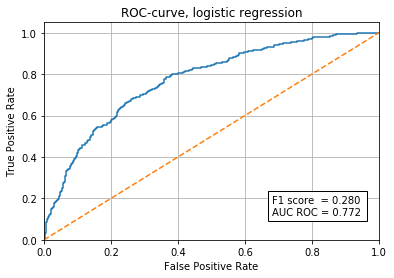

In [15]:
# исследуем логистическую регрессию
model = LogisticRegression(random_state=MODEL_RANDOM_STATE, solver='liblinear')
model.fit(x_train, y_train)
ax = plt.gca()
f1_logistic, auc_logistic = show_roc_and_scores('logistic regression', model, x_valid, y_valid, ax)

In [16]:
add_row_to_models('logistic regression', model, f1_logistic, auc_logistic)

In [17]:
# исследуем небольшой лес и получим значение максимальной глубины дерева, 
# дающее максимальную F1 меру для положительного класса (ушедшие клиенты)
LOW_N_ESTIMATORS = 20
f1_local_best = .0 # переменная для сохранения локально лучшей F1 меры положительного класса
model_local_best = model # переменная для сохранения локально лучшей модели (по величине F1 для положительного класса)
model_local_best_name = '' # переменная для сохранения названия локально лучшей модели (по величине F1 для положительного класса)

In [18]:
def local_best_updated(model, f1): # функция для обновления локально лучшей модели
    global f1_local_best, model_local_best
    if f1 > f1_local_best:
        f1_local_best = f1
        model_local_best = model
        return True
    else: 
        return False

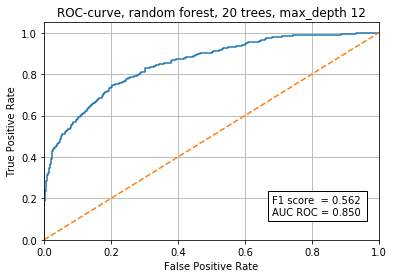

In [19]:
max_depth_best = 1 # глобальная переменная, рассчитаем ее ниже при небольшом кол-ве деревьев
# в дальнейшем исследовании леса будем использовать ее

for depth in range(1, 16):
    model = RandomForestClassifier(random_state = MODEL_RANDOM_STATE, n_estimators = LOW_N_ESTIMATORS, max_depth = depth)
    model.fit(x_train, y_train)
    f1_low_est = f1_score(y_valid, model.predict(x_valid))
    if local_best_updated(model, f1_low_est):
        max_depth_best = depth
        model_local_best_name = f'random forest, {LOW_N_ESTIMATORS} trees, max_depth {max_depth_best}'
ax = plt.gca()
f1_forest_low, auc_forest_low = show_roc_and_scores(model_local_best_name, model_local_best, x_valid, y_valid, ax)
add_row_to_models(model_local_best_name, model_local_best, f1_forest_low, auc_forest_low)

In [20]:
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601


In [21]:
# теперь исследуем случайный лес для разного кол-ва деревьев с полученным ранее лучшим ограничением макс глубины
# создадим функцию, которая при заданных пределах и шаге n_estimators определяет лучшую модель
# и рисует график зависимости F1 полученных моделей для визуальной оценки

n_estimators_best = 2 # глобальная переменная,  в ней сохраним n_estimators для лучшей модели леса
auc_local_best = .0 # переменная для сохранения локально лучшего auc_roc модели 
f1_local_best = .0 # обнулим лучшую F1 меру перед исследованием леса по параметру кол-во оценщиков

def forest_research(lo_est, hi_est, step, max_depth=max_depth_best, show_best=True):
    global n_estimators_best, model_local_best_name, auc_local_best
    f1_scores = pd.Series(dtype=float) # создадим серию для запоминания F1 каждой из созданных моделей (для визуализации)
    models = pd.Series(dtype=object) # создадим серию для запоминания каждой из созданных моделей
    for n_est in range(lo_est, hi_est + 1, step): # в цикле создаем модели, определяем F1 для каждой, сохраняем (для визуализации)
        model = RandomForestClassifier(random_state=MODEL_RANDOM_STATE, n_estimators=n_est, max_depth=max_depth)
        model.fit(x_train, y_train)
        f1_scores.loc[n_est] = f1_score(y_valid, model.predict(x_valid))
        models.loc[n_est] = model
    n_est_inner_best = f1_scores.idxmax() # определяем модель с лучшей F1 для текущего вызова функции
    forest_inner_best = models[n_est_inner_best] 
    forest_inner_best_name = f'random forest, {n_est_inner_best} trees, max_depth {max_depth}'
    f1_inner_best = f1_scores[n_est_inner_best]
    fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax_1 = f1_scores.plot(grid=True, title=f'Method: random forest, max_depth = {max_depth}', ax=ax_1)
    ax_1.set(ylabel='F1 score', xlabel='number of estimators')
    if show_best:
        ax_1.axvline(x=n_est_inner_best, color = 'r', alpha=.5)
        annotation = 'The best model: \n' + f'n_estimators = {n_est_inner_best}\n' + f'F1 score   = {f1_inner_best:>6.3f}'
        n=ax_1.annotate(annotation, xy=(TEXT_X, TEXT_Y), xycoords=ax_1.transAxes, bbox=dict(boxstyle='square', fc='white', ec='black'))
    if local_best_updated(forest_inner_best, f1_inner_best):
        n_estimators_best = n_est_inner_best
        model_local_best_name = forest_inner_best_name
        f1, auc_local_best = show_roc_and_scores(model_local_best_name, model_local_best, x_valid, y_valid, ax_2)
    else:
        f1, auc = show_roc_and_scores(forest_inner_best_name, forest_inner_best, x_valid, y_valid, ax_2)
    # return best_param, best_accuracy, models[best_param]

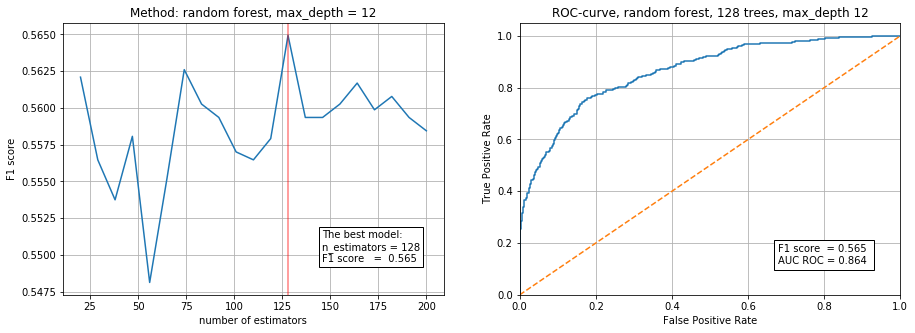

In [22]:
forest_research(20, 200, 9)

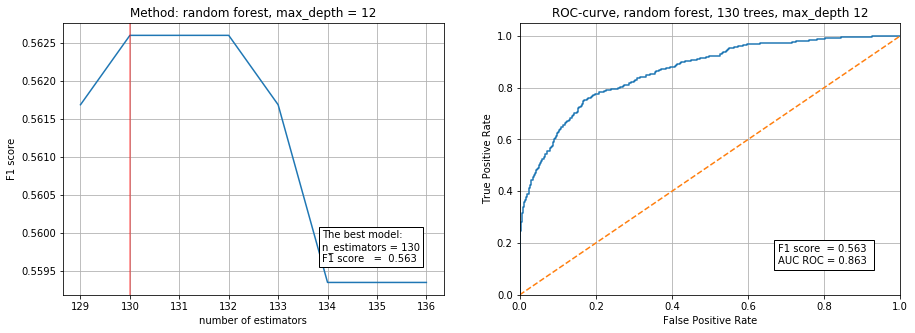

In [23]:
# исследуем более подробно несколько локальных пиков
forest_research(129, 136, 1)

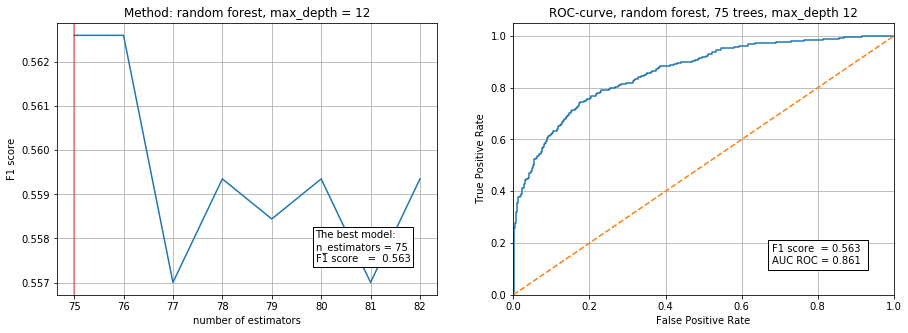

In [24]:
forest_research(75, 82, 1)

In [25]:
# сохраним параметры лучшей модели леса
add_row_to_models(model_local_best_name, model_local_best, f1_local_best, auc_local_best)

In [26]:
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584


## Выводы
- Логистическая регрессия при дефолтных настройках и без предобработки данных для учета несбалансированности работает явно неудовлетворительно, даже близко не приближаясь к намеченным целям 
- Случайных лес работает заметно лучше. Однако и этот алгоритм не справился с задачей "в лоб".

# 3. Борьба с дисбалансом

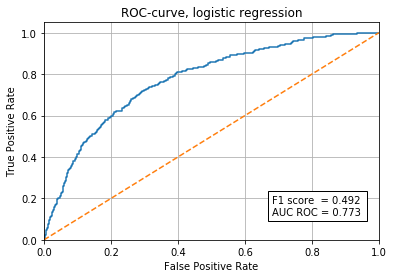

In [27]:
# посмотрим на качество логистической регрессии с параметром class_weight='balanced'
model = LogisticRegression(random_state=MODEL_RANDOM_STATE, class_weight='balanced', solver='liblinear')
model.fit(x_train, y_train)
ax = plt.gca()
f1_logistic, auc_logistic = show_roc_and_scores('logistic regression', model, x_valid, y_valid, ax)

In [28]:
# сохраним данные для логистической регрессии с параметром class_weight='balanced'
add_row_to_models('logistic regression, class_weighted', model, f1_logistic, auc_logistic)

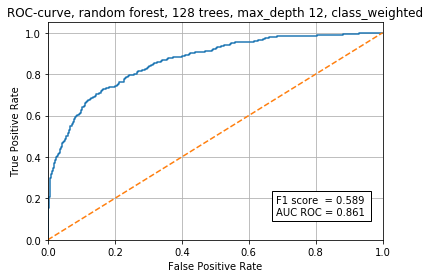

In [29]:
# переобучим модель леса с наилучшими параметрами, полученными ранее, но с параметром class_weight='balanced'
model = RandomForestClassifier(random_state=MODEL_RANDOM_STATE, n_estimators=n_estimators_best, max_depth=max_depth_best, class_weight='balanced')
model.fit(x_train, y_train)
ax = plt.gca()
model_name = f'random forest, {n_estimators_best} trees, max_depth {max_depth_best}, class_weighted'
f1, auc = show_roc_and_scores(model_name, model, x_valid, y_valid, ax)
add_row_to_models(model_name, model, f1, auc)

In [30]:
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"logistic regression, class_weighted",0.492417,0.772716
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182


In [31]:
# изученим возможности upsampling и downsampling по улучшению качества получаемых моделей
# для этого создадим функции увеличения положительного класса и уменьшение отрицательного
SHUFFLE_RANDOM_STATE = 134

def split_classes(x, y):
    filter_zero = y == 0
    filter_one = y == 1
    x_zero = x[filter_zero]
    y_zero = y[filter_zero]
    x_one = x[filter_one]
    y_one = y[filter_one]
    return x_zero, x_one, y_zero, y_one

def upsampling(x, y, repeat):
    x_zero, x_one, y_zero, y_one = split_classes(x, y)
    x_upsample = pd.concat([x_zero] + [x_one] * repeat)
    y_upsample = pd.concat([y_zero] + [y_one] * repeat)
    return shuffle(x_upsample, y_upsample, random_state = SHUFFLE_RANDOM_STATE)

def downsampling(x, y, fraction):
    x_zero, x_one, y_zero, y_one = split_classes(x, y)
    x_zero = x_zero.sample(frac=fraction, random_state = SHUFFLE_RANDOM_STATE)
    y_zero = y_zero.sample(frac=fraction, random_state = SHUFFLE_RANDOM_STATE)
    x_downsample = pd.concat([x_zero, x_one])
    y_downsample = pd.concat([y_zero, y_one])
    return shuffle(x_downsample, y_downsample, random_state = SHUFFLE_RANDOM_STATE)

In [32]:
# для исследования моделей при разной степени увеличения положительного класса, создадим функцию
# которая будет это делать для разных интересующих нас методов моделирования - логистической регрессии и случайного леса
def try_model_up(model_method, **kw_model):
    fig, ax_array = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    ax_array = ax_array.reshape([4])
    f1_best = .0
    for repeat in range(1, 5):
        x_train_upsample, y_train_upsample = upsampling(x_train, y_train, repeat)
        model = model_method(random_state=MODEL_RANDOM_STATE, **kw_model)
        model.fit(x_train_upsample, y_train_upsample)
        model_name = type(model).__name__ + f', upsampling positive class * {repeat}'
        ax = ax_array[repeat - 1]
        f1, auc = show_roc_and_scores(model_name, model, x_valid, y_valid, ax)
        if f1 > f1_best:
            f1_best = f1
            auc_best = auc
            model_best = model
            model_best_name = model_name
    return model_best_name, model_best, f1_best, auc_best

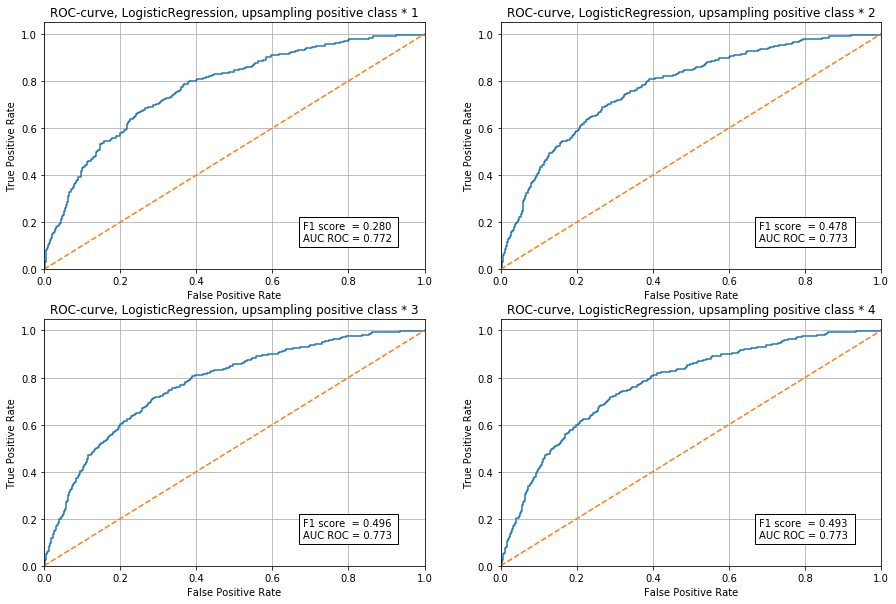

In [33]:
logistic_name, model_logistic, f1_logistic, auc_logistic = try_model_up(LogisticRegression, solver='liblinear')

In [34]:
# добавим в нашу таблицу исследованных моделей данные для лучшего метода upsampling для логистической регрессии
add_row_to_models(logistic_name, model_logistic, f1_logistic, auc_logistic)

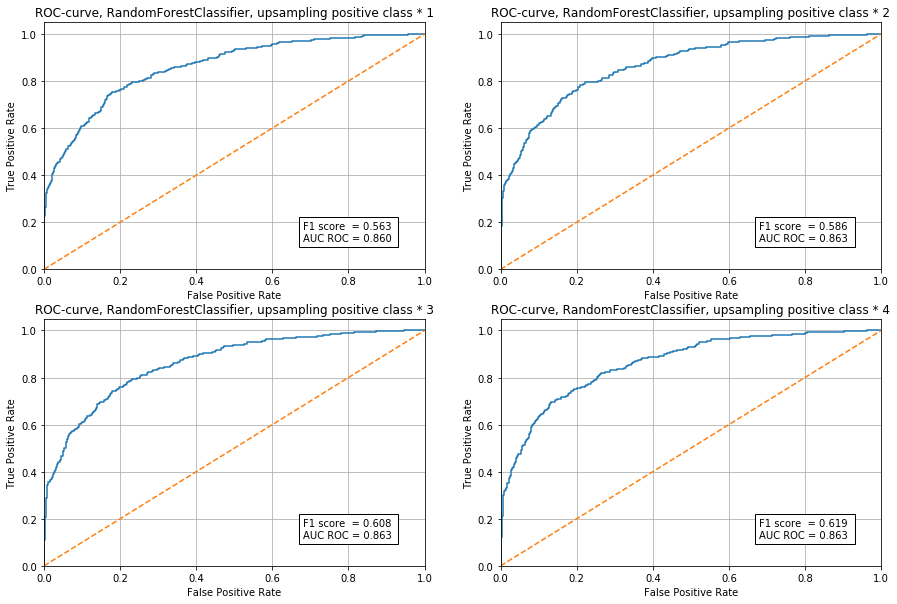

In [35]:
forest_name, model_forest, f1_forest, auc_forest = try_model_up(RandomForestClassifier, n_estimators=n_estimators_best, max_depth=max_depth_best)

In [36]:
# добавим в нашу таблицу исследованных моделей данные для лучшего метода upsampling для случайного леса
add_row_to_models(forest_name, model_forest, f1_forest, auc_forest)

In [37]:
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"logistic regression, class_weighted",0.492417,0.772716
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505


Мы достигли поставленной перед настоящим исследованием цели, тем не менее изучим и downsampling для сравнения 

In [38]:
# создадим аналогичную функцию для исследования downsampling 
def try_model_down(model_method, **kw_model):
    fig, ax_array = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    ax_array = ax_array.reshape([4])
    f1_best = .0
    for i, fraction in enumerate([1, .75, .5, .25]):
        x_train_downsample, y_train_downsample = downsampling(x_train, y_train, fraction)
        model = model_method(random_state=MODEL_RANDOM_STATE, **kw_model)
        model.fit(x_train_downsample, y_train_downsample)
        model_name = type(model).__name__ + f', downsampling negative class * {fraction}'
        ax = ax_array[i]
        f1, auc = show_roc_and_scores(model_name, model, x_valid, y_valid, ax)
        if f1 > f1_best:
            f1_best = f1
            auc_best = auc
            model_best = model
            model_best_name = model_name
    return model_best_name, model_best, f1_best, auc_best

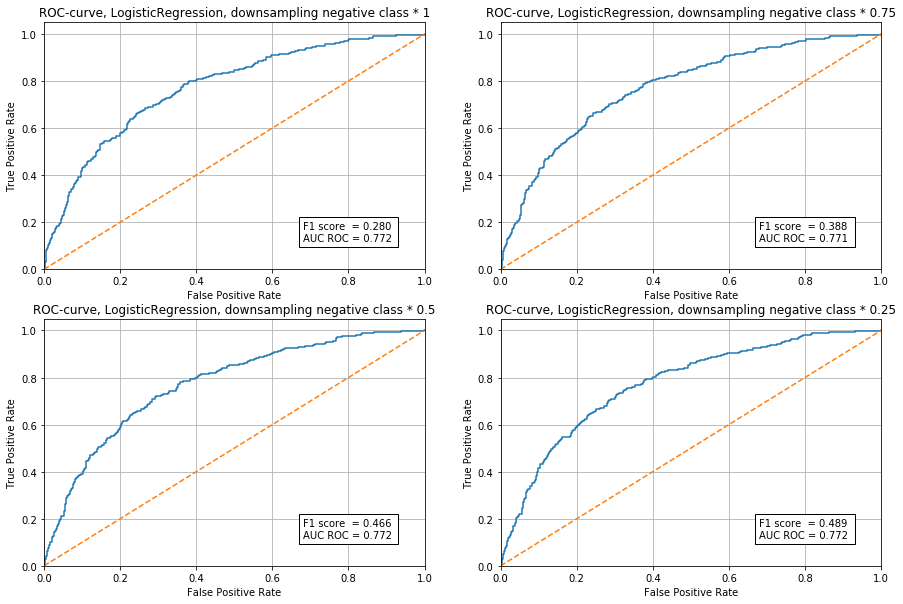

In [39]:
logistic_name, model_logistic, f1_logistic, auc_logistic = try_model_down(LogisticRegression, solver='liblinear')

In [40]:
add_row_to_models(logistic_name, model_logistic, f1_logistic, auc_logistic)

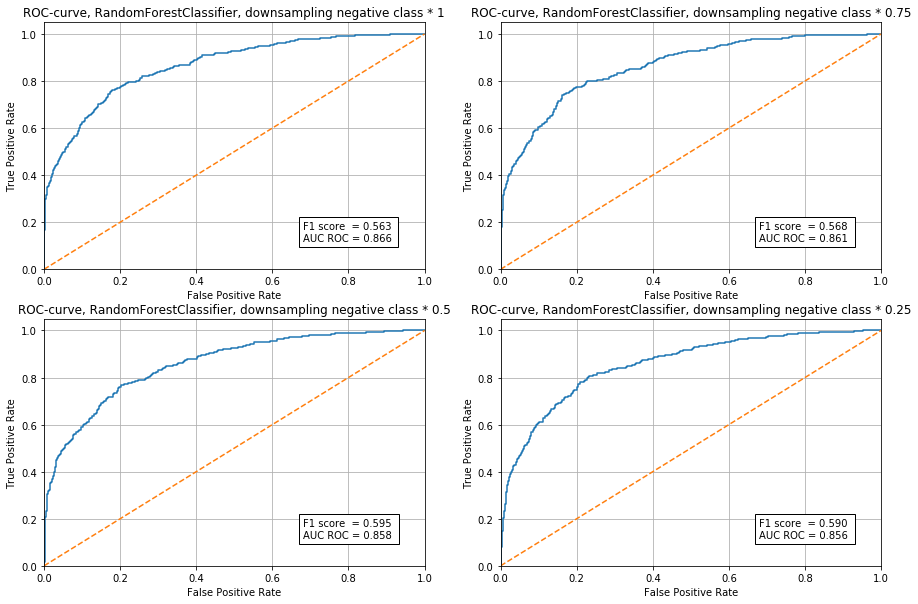

In [41]:
forest_name, model_forest, f1_forest, auc_forest = try_model_down(RandomForestClassifier, n_estimators=n_estimators_best, max_depth=max_depth_best)

In [42]:
add_row_to_models(forest_name, model_forest, f1_forest, auc_forest)

In [43]:
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"logistic regression, class_weighted",0.492417,0.772716
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647


Upsampling продемонстрировал лучший результат и для логистической регрессии (которая все равно работает явно неудовлетворительно) и для случайного леса. Вероятно, это связано с тем, что исходных данных недостаточно, и удаление данных из набора для обучения в целях балансирования классов слишком расточительно.

In [44]:
# попробуем применить одновременно и downsampling и upsampling
# создадим функцию, которая выполнять такую процедуру с заданными repeat и fraction
def try_model_up_down(model_method, repeat, fraction, **kw_model):
    x_train_upsample, y_train_upsample = upsampling(x_train, y_train, repeat)
    x_train_downsample, y_train_downsample = downsampling(x_train_upsample, y_train_upsample, fraction)
    model = model_method(random_state=MODEL_RANDOM_STATE, **kw_model)
    model.fit(x_train_downsample, y_train_downsample)
    model_name = type(model).__name__ + f', up positive * {repeat} down negative * {fraction}'
    ax = plt.gca()
    f1, auc = show_roc_and_scores(model_name, model, x_valid, y_valid, ax)
    return model_name, model, f1, auc

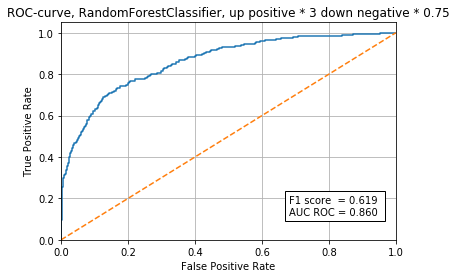

In [45]:
forest_name, model_forest, f1_forest, auc_forest = try_model_up_down(RandomForestClassifier, 3, .75, n_estimators=n_estimators_best, max_depth=max_depth_best)

In [46]:
add_row_to_models(forest_name, model_forest, f1_forest, auc_forest)
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"logistic regression, class_weighted",0.492417,0.772716
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647
"RandomForestClassifier, up positive * 3 down negative * 0.75",0.619048,0.860395


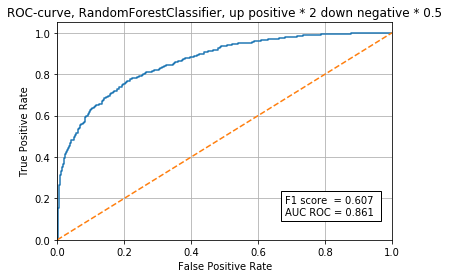

In [47]:
forest_name, model_forest, f1_forest, auc_forest = try_model_up_down(RandomForestClassifier, 2, .5, n_estimators=n_estimators_best, max_depth=max_depth_best)

In [48]:
add_row_to_models(forest_name, model_forest, f1_forest, auc_forest)
models_studied.drop(columns='model')

,f1_valid,auc_valid
logistic regression,0.280374,0.771645
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"logistic regression, class_weighted",0.492417,0.772716
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647
"RandomForestClassifier, up positive * 3 down negative * 0.75",0.619048,0.860395


In [49]:
# отсортируем по убыванию F1-меры
models_studied.sort_values(by='f1_valid', ascending=False, inplace=True)
models_studied.drop(columns='model')

,f1_valid,auc_valid
"RandomForestClassifier, up positive * 3 down negative * 0.75",0.619048,0.860395
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505
"RandomForestClassifier, up positive * 2 down negative * 0.5",0.606742,0.861274
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182
"random forest, 128 trees, max_depth 12",0.564935,0.863584
"random forest, 20 trees, max_depth 12",0.562092,0.849601
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625
"logistic regression, class_weighted",0.492417,0.772716
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716


## Выводы.
- Метод логистической регрессии не справился с поставленной задачей - ни при каких использованных нами методах борьбы с несбалансированностью F1 мера для положительного класса даже близко не приблизилась к поставленной цели
- Использование параметра class_weight='balanced' не позволило нам достигнуть поставленных перед исследованием целей.
- Метод случайного леса позволил построить нам несколько моделей, достигнувших целей по метрике F1
- Upsampling продемонстрировал лучший результат по сравнению с downsampling и для логистической регрессии (которая все равно работает явно неудовлетворительно) и для случайного леса. Вероятно, это связано с тем, что исходных данных недостаточно, и удаление данных из набора для обучения в целях балансирования классов слишком расточительно.
- В числе лидеров две модели, в которых одновременно были применены и downsampling для отрицательного и upsampling для положительного классов.

# 4. Тестирование модели

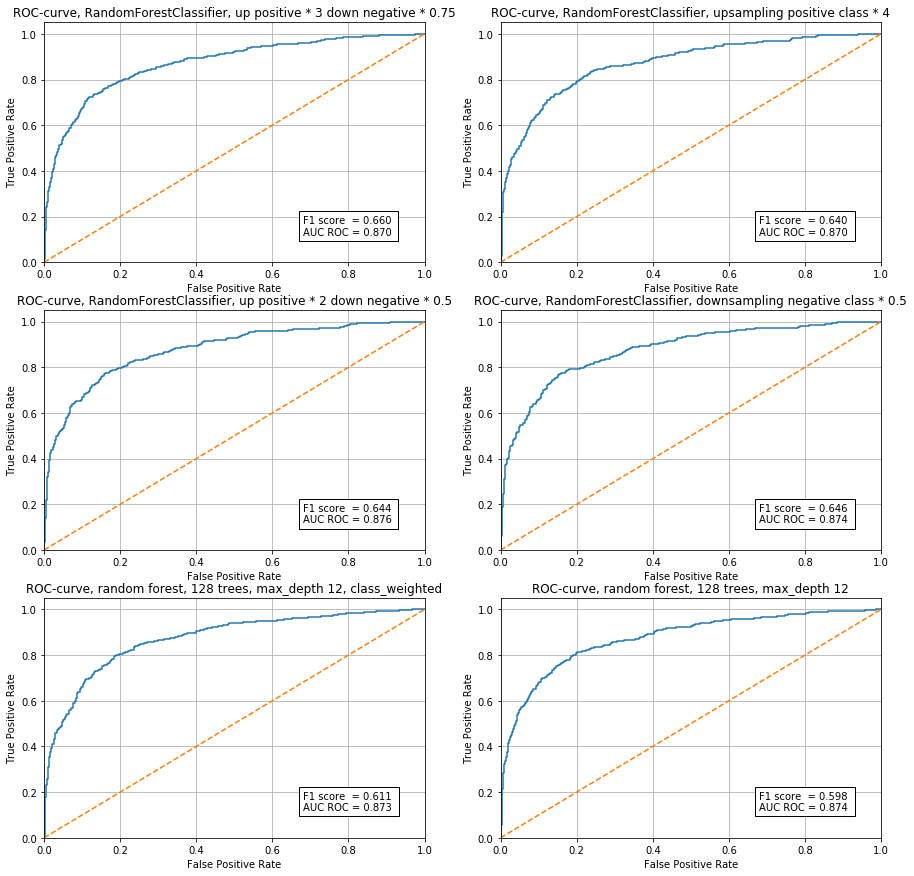

In [50]:
# посмотрим на результаты лучших моделей на тестовой выборке
fig, ax_array = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
ax_array = ax_array.reshape([6])

for i in range(6):
    ax = ax_array[i]
    model_name = models_studied.index[i]
    f1, auc = show_roc_and_scores(model_name, models_studied.loc[model_name, 'model'], x_test, y_test, ax)
    models_studied.loc[model_name, 'f1_test'] = f1
    models_studied.loc[model_name, 'auc_test'] = auc

In [51]:
models_studied.drop(columns='model')

,f1_valid,auc_valid,f1_test,auc_test
"RandomForestClassifier, up positive * 3 down negative * 0.75",0.619048,0.860395,0.659978,0.870371
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505,0.639906,0.869744
"RandomForestClassifier, up positive * 2 down negative * 0.5",0.606742,0.861274,0.644281,0.876310
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647,0.645885,0.874053
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182,0.610667,0.872883
"random forest, 128 trees, max_depth 12",0.564935,0.863584,0.598187,0.874076
"random forest, 20 trees, max_depth 12",0.562092,0.849601,NaN,NaN
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625,NaN,NaN
"logistic regression, class_weighted",0.492417,0.772716,NaN,NaN
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716,NaN,NaN


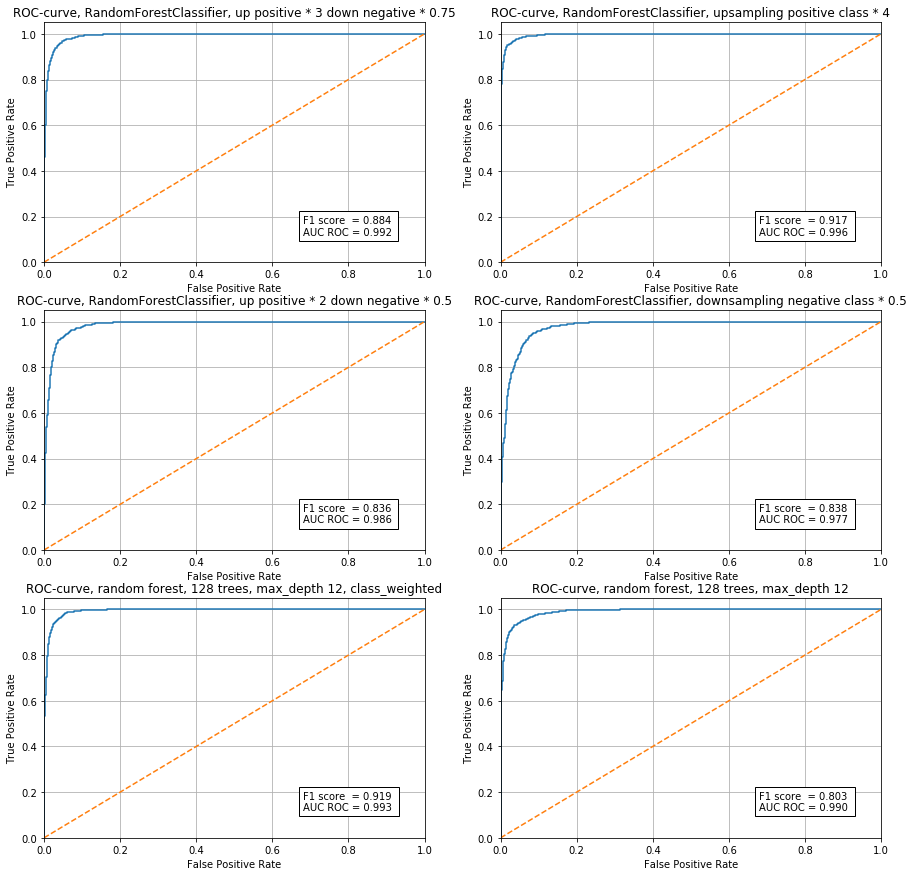

In [52]:
# посмотрим до какого уровня доходило обучение на разных моделях - проверим наши целевые метрики на обучающем наборе
fig, ax_array = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
ax_array = ax_array.reshape([6])

for i in range(6):
    ax = ax_array[i]
    model_name = models_studied.index[i]
    f1, auc = show_roc_and_scores(model_name, models_studied.loc[model_name, 'model'], x_train, y_train, ax)
    models_studied.loc[model_name, 'f1_train'] = f1
    models_studied.loc[model_name, 'auc_train'] = auc

In [53]:
models_studied.drop(columns='model')

,f1_valid,auc_valid,f1_test,auc_test,f1_train,auc_train
"RandomForestClassifier, up positive * 3 down negative * 0.75",0.619048,0.860395,0.659978,0.870371,0.883602,0.992072
"RandomForestClassifier, upsampling positive class * 4",0.618868,0.862505,0.639906,0.869744,0.916508,0.995851
"RandomForestClassifier, up positive * 2 down negative * 0.5",0.606742,0.861274,0.644281,0.876310,0.835769,0.985555
"RandomForestClassifier, downsampling negative class * 0.5",0.594595,0.857647,0.645885,0.874053,0.838224,0.977397
"random forest, 128 trees, max_depth 12, class_weighted",0.588905,0.861182,0.610667,0.872883,0.919159,0.993222
"random forest, 128 trees, max_depth 12",0.564935,0.863584,0.598187,0.874076,0.803247,0.990064
"random forest, 20 trees, max_depth 12",0.562092,0.849601,NaN,NaN,NaN,NaN
"LogisticRegression, upsampling positive class * 3",0.49641,0.772625,NaN,NaN,NaN,NaN
"logistic regression, class_weighted",0.492417,0.772716,NaN,NaN,NaN,NaN
"LogisticRegression, downsampling negative class * 0.25",0.489083,0.7716,NaN,NaN,NaN,NaN


## Выводы
- Целевые показатели подтверждены и на тестовой выборке
- Обращает на себя внимание, что лидеры по метрике F1-меры для положительного класса не являются лидерами по метрике AUC-ROC. Различие хоть и незначительное, но заметное, подтвержденное как на валидационной выборке, так и на тестовой. Данный факт объясним - F1-мера для положительного класса считается как среднее геометрическое точности и полноты положительного класса, т.е. она строится только на данных, связанных с положительным классом (TP, FP, FN) и никак не учитывает TN. ROC-кривая - это зависимость TPR от FPR, в расчет которых входят все четыре величины из матрицы ошибок (CM).
- Заметим, что ROC-кривая, полученная нами для всех исследованных моделей, позволяет установить порог определения положительного класса, исходя из баланса бизнес-интересов. Стремление к высокой полноте (а полнота для положительного класса просто эквивалентна TPR, true positive rate) будет ограничиваться кол-вом ошибок при определении отрицательного класса. С точки зрения бизнеса банка ошибочное отнесение какого-то клиента к потенциальному претенденту на расторжение контракта с банком, очевидно, не является критической ошибкой, такого рода ошибка лишь увеличивает расходы, запланированные банком на удержание клиента. Таким образом, имея стоимость привлечения нового клиента и запланированную стоимость расходов на удеражние одного клиента легко вычислить точку на ROC-кривой, однозначно определив требуемый порог.